# Survival analysis

## Elements of survival analysis
- **Survivor Function**: The survivor function, $S(t)$, describes the probability that an individual or subject will survive beyond a given time $t$, hence $S(t) = P(T > t)$. It is a decreasing function that starts at 1 (100% survival at time zero) and decreases as time progresses: $S(t) = P(T \geq t) = 1-F(t)$, where F(t) is cumulative distribution function.
- **Hazard Function**: The hazard function, $h(t)$, represents the instantaneous rate at which events occur at time $t$, given that the subject has survived up until time $t$. It describes the risk of the event happening in the next instant, conditional on survival until that time.

## TODO

Meeting with Elena/Vaselka (09.09.24.):
Two parallel tracks:


###  (1) Timestamp-wise: online prediction of risk
- [ ] use risk score as label for regression

### (2) Truck-wise: characterisation of vehicle
- [ ] like in the original paper of the winners, only use the last timestep for extracting the label (here: risk score)
- [ ] apply deep learning (CNN, RNN) and compare to published results

### Other input
- [ ] plot evolution of risk score over time
    - is there some random yoyo behaviour or is it steadily going down? 
- [ ] plot class 0 against the rest (do not make use of the original classes) and differentiate between trucks that were repaired and trucks that were not
- [ ] only consider itemsets of length 8
- [ ] apply BIDE (prefix span) to extract closed patterns
- [ ] time dependent models
- [ ] random survival forest

### Own ideas:
- [ ] https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#Feature-Selection:-Which-Variable-is-Most-Predictive?
- [x] Overfitting: Train and test set contain same cars, train and validation set contain same cars
    - per car, select a random sample
- [ ] ~~Remove outliers from data?~~
- [ ] Left-censored?

In [1]:
from conscious_engie_icare.scania import preprocessing, dataset, util
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sksurv.linear_model import CoxPHSurvivalAnalysis
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Load data.

In [2]:
df_ts = dataset.load_ts(add_labels=True)
df_repair = dataset.load_repairs()
df_ts.head()

100% 1122452/1122452 [00:12<00:00, 91526.28it/s] 


,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35,delta_time,class
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,...,1984.0,8.0,784.0,150228.0,261904.0,93172.0,17874.0,452.0,498.8,0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,...,1984.0,8.0,784.0,150228.0,261905.0,93172.0,17874.0,452.0,498.6,0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,NaN,NaN,NaN,NaN,...,2441.0,12.0,1420.0,204832.0,313485.0,106464.0,19306.0,452.0,490.4,0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,NaN,NaN,NaN,NaN,...,2522.0,12.0,1444.0,211688.0,318901.0,107745.0,19406.0,453.0,489.8,0
4,0,21.0,365550.0,15295.0,14966985.0,2720.0,NaN,NaN,NaN,NaN,...,2562.0,12.0,1445.0,213956.0,323997.0,109514.0,19535.0,454.0,489.0,0


Preprocessing:

In [3]:
df_ts_preprocessed = preprocessing.interpolate_ts(df_ts)
df_ts_preprocessed = preprocessing.remove_empty_rows(df_ts_preprocessed)
list_of_attribute_columns = dataset.extract_list_of_attribute_columns(df_ts_preprocessed)
list_of_sensor_bins = util.merge_lists_with_one_element(list_of_attribute_columns)
# ATTENTION: IF THE SUM IS 0, THEN THE VALUE IS NAN. IN THIS CASE, WE CAN GIVE THE HISTOGRAM A UNIFORM DISTRIBUTION OR REMOVE THE VALUES!
# df_ts_preprocessed, _ = preprocessing.normalize_by_total_count(df_ts_preprocessed, list_of_sensor_bins, correct_histograms=True)

Removing 1217 rows with missing values.


Convert into X, y format:

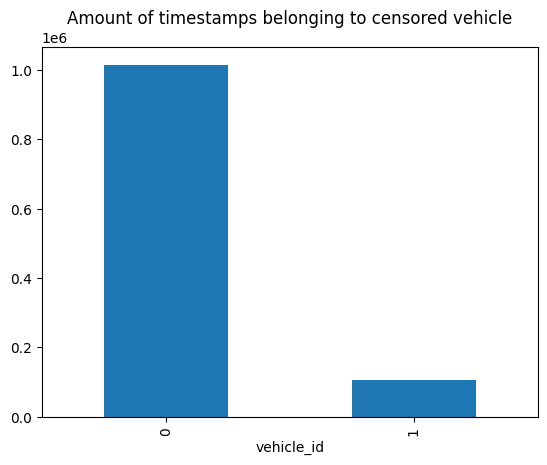

In [4]:
# Example data shapes:
# X: (1200000, 105) - Feature matrix
# y: (1200000,) - Time-to-event data
# c: (1200000,) - Censoring indicator (0 for censored, 1 for event observed)
# t: (1200000,) - Truck indicator (= vehicle_id)

# X and t
X = df_ts_preprocessed[dataset.ATTRIBUTE_COLUMNS].to_numpy()
t = df_ts_preprocessed['vehicle_id'].to_numpy()

# censored vehicles
was_repaired = df_repair.set_index('vehicle_id')['in_study_repair'].to_dict()
was_repaired = {str(k): v for k, v in was_repaired.items()}
c = df_ts_preprocessed['vehicle_id'].map(was_repaired)

# visualize censored vehicles
ax = c.value_counts().plot.bar()
ax.set_title('Amount of timestamps belonging to censored vehicle');

# Convert y and c into a structured array suitable for survival analysis
delta_time = df_ts_preprocessed['delta_time']
y = np.array([(censoring == 1, time) for censoring, time in zip(c, delta_time)],
               dtype=[('event', '?'), ('time', '<f8')])

# Make sure that data formats are correct
assert len(df_ts_preprocessed) <= len(df_ts)
assert X.shape == (len(df_ts_preprocessed), len(dataset.ATTRIBUTE_COLUMNS))
assert len(t) == len(X)
assert len(c) == len(X)
assert len(delta_time) == len(X)
assert len(y) == len(X)

Train-test split:

'There are 18838 trucks in the training and 4710 trucks in the test set.'

'There are 896315 readouts in the training and 224920 readouts in the test set.'

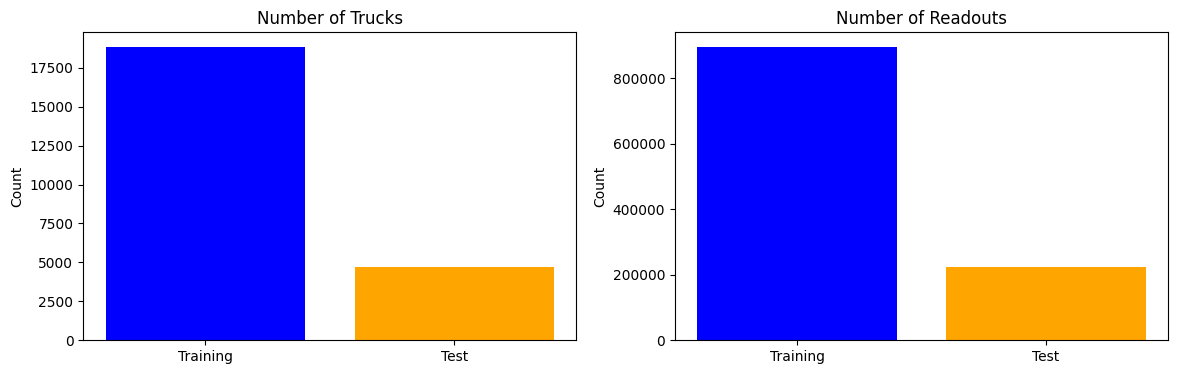

In [5]:
# Data leakage
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base train-test split on trucks (not single timesteps)
unique_truck_ids = np.unique(t)
ts_train, ts_test = train_test_split(unique_truck_ids, test_size=0.2, random_state=42)
ts_train_set = set(ts_train)
train_mask = np.array([x in ts_train_set for x in t])
ts_test_set = set(ts_test)
test_mask = np.array([x in ts_test_set for x in t])
t_train = t[train_mask]
t_test = t[test_mask]
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

assert len(X_train) + len(X_test) == len(X)
assert len(X_train) == len(y_train)

display(f"There are {len(ts_train)} trucks in the training and {len(ts_test)} trucks in the test set.")
display(f"There are {len(X_train)} readouts in the training and {len(X_test)} readouts in the test set.")

# Create figure and axes for the bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Data for the first bar plot (number of trucks)
axes[0].bar(['Training', 'Test'], [len(ts_train), len(ts_test)], color=['blue', 'orange'])
axes[0].set_title('Number of Trucks')
axes[0].set_ylabel('Count')

# Data for the second bar plot (number of readouts)
axes[1].bar(['Training', 'Test'], [len(X_train), len(X_test)], color=['blue', 'orange'])
axes[1].set_title('Number of Readouts')
axes[1].set_ylabel('Count');

# Linear models

## Cox proportional hazards model (CoxPHSurvivalAnalysis)

The Cox Proportional Hazards model is a survival analysis method that models the hazard function $h(t \mid \mathbf{x})$ for an individual with covariates $\mathbf{x} = (x_1, x_2, \dots, x_p)$ at time $t$ as:


$h(t \mid \mathbf{x}) = h_0(t) \cdot \exp(\mathbf{\beta}^\top \mathbf{x})$

Here, $h_0(t)$ is the baseline hazard function, which is unspecified and common to all individuals. It characterizes how the hazard functions changes as a function of survival time. The vector $\mathbf{\beta} = (\beta_1, \beta_2, \dots, \beta_p)$ represents the coefficients for the covariates, and $\exp(\mathbf{\beta}^\top \mathbf{x})$ is the risk score, determining how the covariates modify the hazard. The key assumption of the model is that the hazard ratio between two individuals is constant over time, meaning the ratio of their hazards is independent of time:

$\frac{h(t \mid \mathbf{x}_1)}{h(t \mid \mathbf{x}_2)} = \exp\left(\mathbf{\beta}^\top (\mathbf{x}_1 - \mathbf{x}_2)\right)$

This makes the model semi-parametric, as it does not require explicit specification of $h_0(t)$.

<div style="border: 1px solid #ccc; border-radius: 5px; padding: 10px; margin: 10px 0;">
    <details class="details-box">
        <summary style="cursor: pointer; font-weight: bold;">Click to toggle more details on why the model is semi-parametric</summary>
        <p style="margin-top: 10px;">
            A semi-parametric model is a type of statistical model that combines elements of both parametric and non-parametric models. In a semi-parametric model:

- **Parametric Component**: The model includes a part where the form of the relationship between variables is specified and involves a finite number of parameters. For example, in the Cox Proportional Hazards model, the parametric component is the linear predictor $\mathbf{\beta}^\top \mathbf{x}$, where $\mathbf{\beta}$ are the parameters that need to be estimated.

- **Non-parametric Component**: Another part of the model does not assume a specific parametric form and can vary more freely. In the Cox model, the baseline hazard function $h_0(t)$ is non-parametric because it is not specified by a particular functional form and is instead estimated from the data.

This blend allows semi-parametric models to be more flexible than fully parametric models while still retaining some structure, making them useful in situations where you want to model certain aspects parametrically but leave other aspects unspecified or data-driven.
        </p>
    </details>
</div>

### Assumtions of CoxPH

- observations are independent
- harards are proportional: the effect of the covariates on the hazard is multiplicative and constant over time. This means that the hazard ratios between individuals are constant across time; the relationship between covariates and the hazard does not change as time progresses.

### Estimate coefficients $\mathbf{\beta} = (\beta_1, \beta_2, \dots, \beta_p)$
Minimizing the negative partial log-likelihood ensures that the estimated coefficients for the covariates best explain the observed relationship between the covariates and the hazard of the event occurring, according to the CoxPH model.

### Notes
Survival analysis (on raw features) --> ill-conditioned

In [6]:
start_time = time.time()
samples = np.random.choice(len(X_train), size=200000, replace=False)
X_train_sample = X_train[samples]
y_train_sample = y_train[samples]
cox_model = CoxPHSurvivalAnalysis()
# Minimize negative partial log-likelihood for provided data
cox_model.fit(X_train_sample, y_train_sample)
end_time = time.time()
print(f'elapsed time: {round(end_time - start_time, 2)} seconds')

/root/miniconda3/envs/compact/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=9.39117e-18): result may not be accurate.
  delta = solve(
/root/miniconda3/envs/compact/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])


elapsed time: 53.29 seconds


The prediction array `y` is a structured array of, where the first of the two elements (`event`) indicates whether the event was observed, and the second element indicates the time of event (if `event=True`), or the last time of obeservation (if `event=False`).

In [7]:
y_train_sample

array([( True, 123.6), (False, 360.2), (False,  70.4), ...,
       (False, 214.8), (False,  92.6), (False, 209.8)],
      dtype=[('event', '?'), ('time', '<f8')])

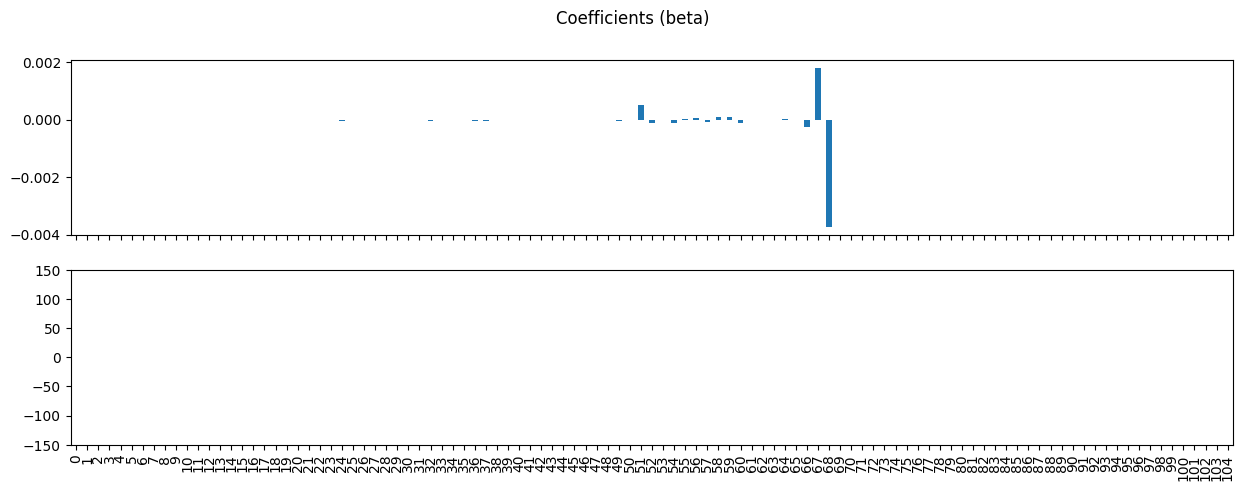

In [8]:
fig, axes = plt.subplots(figsize=(15, 5), nrows=2, sharex=True)
ax = pd.Series(cox_model.coef_).plot.bar(ax=axes[0])
ax = pd.Series(cox_model.coef_).plot.bar(ax=axes[1])
ax.set_ylim(-150, 150);
fig.suptitle('Coefficients (beta)');

## Penalized Cox Models

If we want to estimate the coefficients of many features, the standard Cox model falls apart, because internally it tries to invert a matrix that becomes non-singular due to correlations among features.

In [9]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold

coxnet_pipe = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=0.5, alpha_min_ratio=0.000001, max_iter=100, n_alphas=20, verbose=True))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=1e-06, max_iter=100,
                                        n_alphas=20, verbose=True))])

In [10]:
# overfitting in cross-validation?
start_time = time.time()
estimated_alphas = list(reversed(coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_))
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=0.5)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=25,
    verbose=0
).fit(X_train_sample, y_train_sample)

cv_results = pd.DataFrame(gcv.cv_results_)
end_time = time.time()
print(f'elapsed time: {round(end_time - start_time, 2)} seconds')

/root/miniconda3/envs/compact/lib/python3.8/site-packages/sklearn/pipeline.py:427: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/root/miniconda3/envs/compact/lib/python3.8/site-packages/sklearn/pipeline.py:427: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/root/miniconda3/envs/compact/lib/python3.8/site-packages/sklearn/pipeline.py:427: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/root/miniconda3/envs/compact/lib/python3.8/site-packages/sklearn/pipeline.py:427: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)

elapsed time: 4627.82 seconds


In [11]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3438.929422,310.691568,0.455266,0.227977,[8.205844654654332],{'coxnetsurvivalanalysis__alphas': [8.20584465...,0.584793,0.500000,0.574821,0.514835,0.566443,0.548178,0.034109,19
1,3463.573462,101.534845,0.581387,0.014509,[16.979025662657516],{'coxnetsurvivalanalysis__alphas': [16.9790256...,0.623421,0.615786,0.614033,0.553194,0.637358,0.608758,0.028974,15
2,3355.635641,80.170978,0.586015,0.011470,[35.13194857882994],{'coxnetsurvivalanalysis__alphas': [35.1319485...,0.620104,0.620092,0.588467,0.553035,0.636251,0.603590,0.029652,16
3,2985.932671,299.199987,0.351984,0.287419,[72.69285266822365],{'coxnetsurvivalanalysis__alphas': [72.6928526...,0.500000,0.593717,0.500000,0.545809,0.595459,0.546997,0.042309,20
4,3075.261180,119.849932,0.471798,0.236186,[150.4115496806884],{'coxnetsurvivalanalysis__alphas': [150.411549...,0.634716,0.615722,0.500000,0.550883,0.620709,0.584406,0.051143,18
5,1284.558374,348.158431,0.447760,0.224006,[311.22226528380145],{'coxnetsurvivalanalysis__alphas': [311.222265...,0.572212,0.500000,0.687987,0.556466,0.613633,0.586060,0.062647,17
6,1119.312240,351.234725,0.562623,0.017032,[643.961840789523],{'coxnetsurvivalanalysis__alphas': [643.961840...,0.732336,0.615235,0.683622,0.572121,0.599168,0.640496,0.058848,13
7,870.837163,467.999728,0.573979,0.029727,[1332.4459675623812],{'coxnetsurvivalanalysis__alphas': [1332.44596...,0.728950,0.550592,0.594802,0.657985,0.728761,0.652218,0.071280,12
8,232.097324,341.096938,0.454478,0.227307,[2757.0146925111644],{'coxnetsurvivalanalysis__alphas': [2757.01469...,0.729728,0.726368,0.720144,0.500000,0.726233,0.680495,0.090300,10
9,50.287970,49.328408,0.579863,0.027863,[5704.644090467833],{'coxnetsurvivalanalysis__alphas': [5704.64409...,0.726296,0.720412,0.717017,0.720606,0.719908,0.720848,0.003016,1


Text(0.5, 1.0, 'Hyperparameter tuning (gridsearch) of alpha parameter for coxnet-survival analysis')

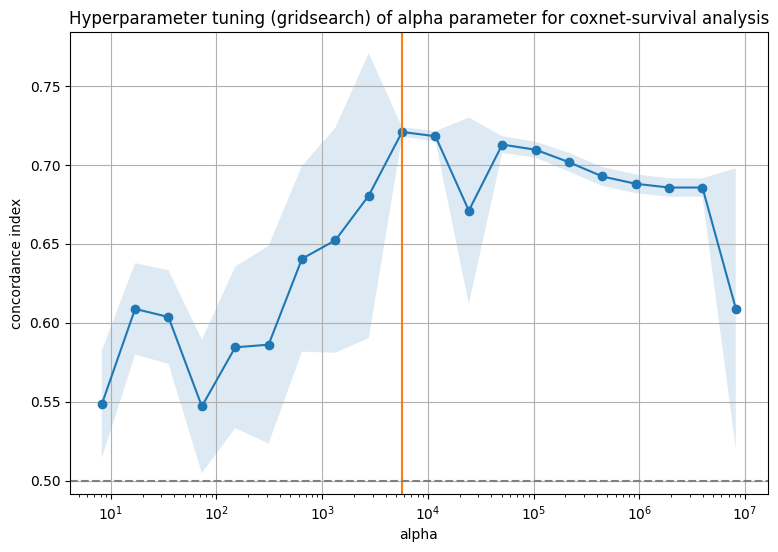

In [32]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean, marker='o')
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)
ax.set_title('Hyperparameter tuning (gridsearch) of alpha parameter for coxnet-survival analysis')

If the best alpha value selected by the `GridSearchCV` is extremely small, it has specific implications related to the regularization in the Coxnet (penalized Cox proportional hazards) model:
In the context of the CoxnetSurvivalAnalysis model, alpha controls the strength of the regularization applied to the model. Regularization is used to prevent overfitting by shrinking the coefficients of the covariates.
- **Lasso (L1) Regularization**: Encourages sparsity by shrinking some coefficients to zero, effectively selecting a subset of the features.
- **Ridge (L2) Regularization**: Shrinks all coefficients but does not set any to zero, distributing the penalty more evenly across all coefficients.
 
An extremely small alpha indicates that the best model according to cross-validation requires minimal regularization, implying that the covariates contribute significantly to the model without needing substantial penalty to prevent overfitting. However, it also suggests a potential risk of overfitting, which should be carefully monitored by evaluating the model's performance on independent validation or test data.
  
<div style="border: 1px solid #ccc; border-radius: 5px; padding: 10px; margin: 10px 0;">
    <details class="details-box">
        <summary style="cursor: pointer; font-weight: bold;">Click to toggle more details on the implications of a small alpha</summary>
        <p style="margin-top: 10px;">

- **Weak Regularization**:
    - An extremely small alpha value implies that the best model, according to cross-validation, requires very weak regularization. This means that the penalty applied to the coefficients is minimal.
    - In practical terms, this suggests that the data does not benefit significantly from regularization, and the unpenalized (or nearly unpenalized) model fits the data well.
- **Complex Model**:
    - With a small alpha, the model coefficients are less penalized, leading to a more complex model where most of the covariates may have non-zero coefficients. The model retains more of the original feature set without enforcing sparsity.
- **Low Multicollinearity or Redundancy**:
    - A small alpha may also indicate that the features in the dataset have low multicollinearity or that they are all contributing useful information. Therefore, there's less need to shrink or eliminate some of the coefficients.
- **Possibly Overfitting**:
    - While a small alpha suggests that the model may fit the training data well, it also raises the possibility of overfitting, especially if the model is overly complex. It’s crucial to ensure that the model generalizes well to unseen data, which is typically evaluated by checking performance on a validation or test set.
        </p>
    </details>
</div>

In [13]:
coxnet_pred = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=0.5, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(X_train_sample, y_train_sample)

/root/miniconda3/envs/compact/lib/python3.8/site-packages/sklearn/pipeline.py:427: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[5704.644090467833],
                                        fit_baseline_model=True))])

Number of non-zero coefficients: 35


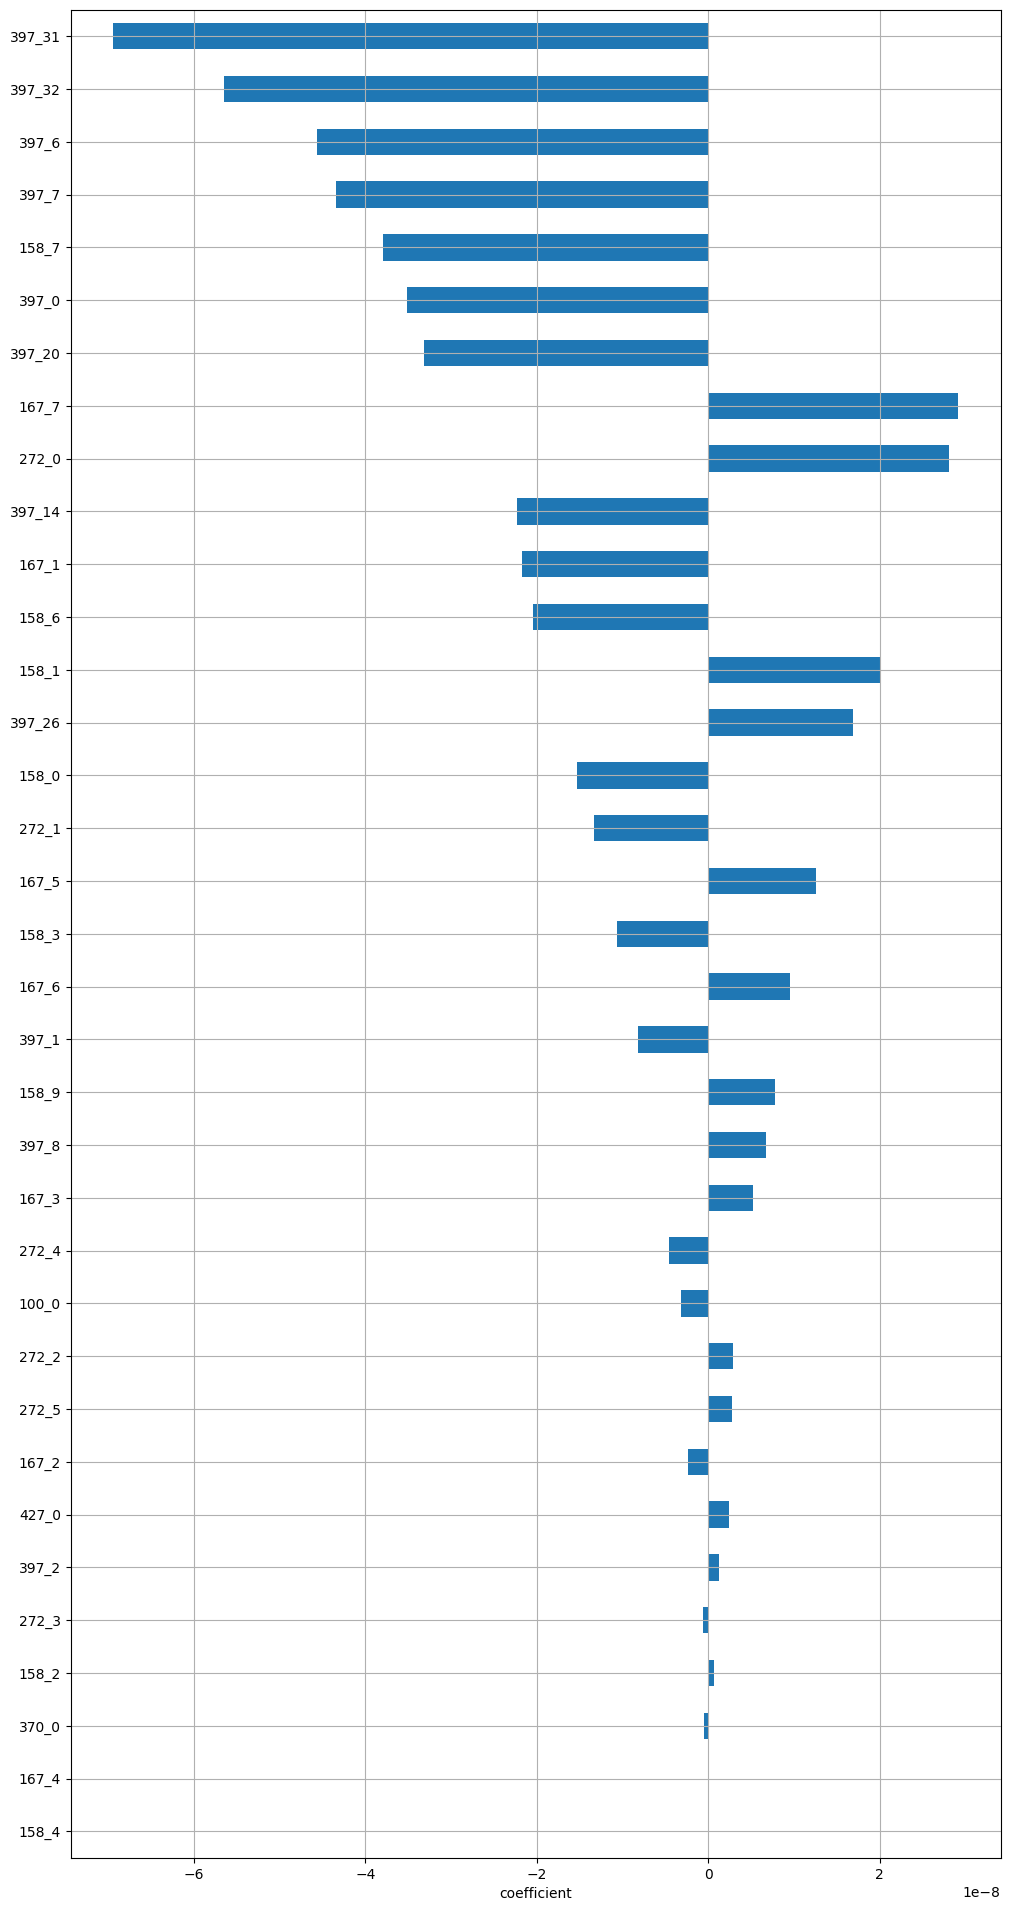

In [14]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
col_names = [item for sublist in list_of_attribute_columns for item in sublist]
best_coefs = pd.DataFrame(best_model.coef_, index=col_names, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(12, 24))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

## Evaluate model

### Survival metrics

#### Concordance index (c-index)
The most frequently used evaluation metric of survival models is the concordance index (c index, c statistic).
It is a measure of **rank correlation between predicted risk scores and observed time points** that is closely related to Kendall’s $\tau$.

- a value of 0.5 denotes a random model
- a value of 1.0 denotes a perfect model
- a value of 0.0 denotes a perfectly wrong model.

### Anomaly metrics 

Convert into an anomaly detection problem.

- ROC curve / AUC
- Accuracy
- F1 score

In [115]:
from sksurv.metrics import concordance_index_censored
SAMPLE = False

start_time = time.time()

if SAMPLE:
    samples = np.random.choice(len(X_test), size=100000, replace=False)
    X_test_sample = X_test[samples] # X_train_sample # X_test  # X_test[samples]
    y_test_sample = y_test[samples] # y_train_sample  # y_test[samples]

# Predict the risk scores on the test set
risk_scores = cox_model.predict(X_test)

# Calculate the concordance index
c_index = concordance_index_censored(y_test["event"], y_test["time"], risk_scores)[0]
print(f"Concordance Index: {c_index:.4f}")
end_time = time.time()
print(f'elapsed time: {round(end_time - start_time, 2)} seconds')

Concordance Index: 0.7256
elapsed time: 17.05 seconds


The `risk_score` expresses the relative risk of an event occurring for each individual in the test set, based on their covariates.

The risk scores obtained from `risk_scores = cox_model.predict(X_test_sample)` in the Cox Proportional Hazards (CoxPH) model represent the relative risk of an event occurring for each individual in the test set, based on their covariates.
Mathematically, the risk score for an individual $i$ with covariates $\mathbf{x}_i$ is:
$\text{Risk Score}_i = \exp(\mathbf{\beta}^\top \mathbf{x}_i)$
where $\mathbf{\beta}$ are the coefficients estimated by the Cox model.

**Interpretation**:
- **High Risk Scores**: Individuals with higher risk scores have a higher relative risk of experiencing the event sooner compared to others with lower risk scores. This means they are more likely to have the event happen earlier.
- **Low Risk Scores**: Conversely, individuals with lower risk scores have a lower relative risk, meaning they are expected to survive longer without experiencing the event, relative to those with higher risk scores.

**No Absolute Prediction**: The CoxPH model does not provide a direct prediction of the exact time until the event occurs. Instead, it ranks individuals by their risk of the event, allowing you to determine which individuals are at higher or lower risk relative to each other.

**Comparative Analysis**: The risk scores can be used to compare different individuals or groups. For example, you might compare the risk scores of individuals with different covariate profiles to see which group is at higher risk of the event.

count    224920.000000
mean          0.659307
std           0.842194
min         -14.200608
25%           0.121244
50%           0.498468
75%           1.068345
max           7.831379
dtype: float64

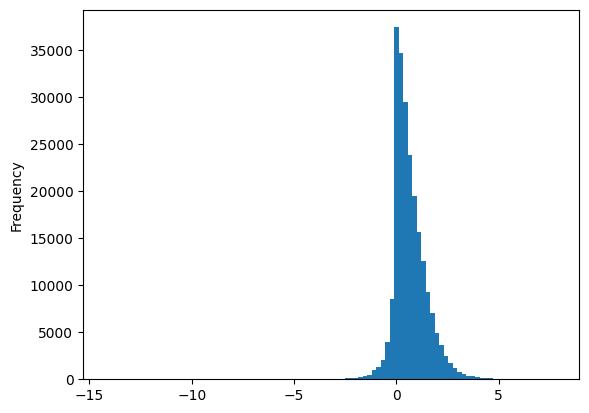

In [117]:
display(pd.Series(risk_scores).describe())
ax = pd.Series(risk_scores).plot.hist(bins=100)

count    224920.000000
mean          0.659307
std           0.842194
min         -14.200608
25%           0.121244
50%           0.498468
75%           1.068345
max           7.831379
dtype: float64

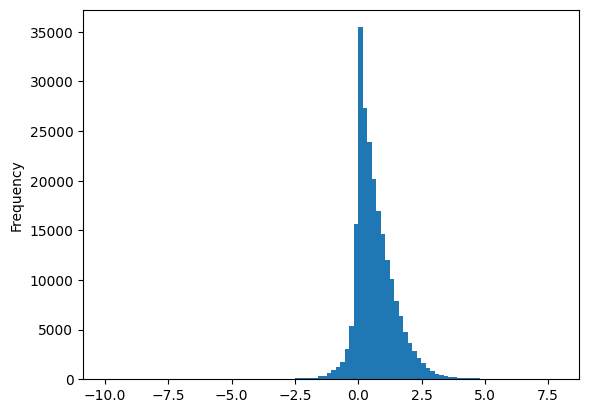

In [118]:
display(pd.Series(risk_scores).describe())
s = pd.Series(risk_scores)
ax = s[(s > -10) & (s < 10)].plot.hist(bins=100)

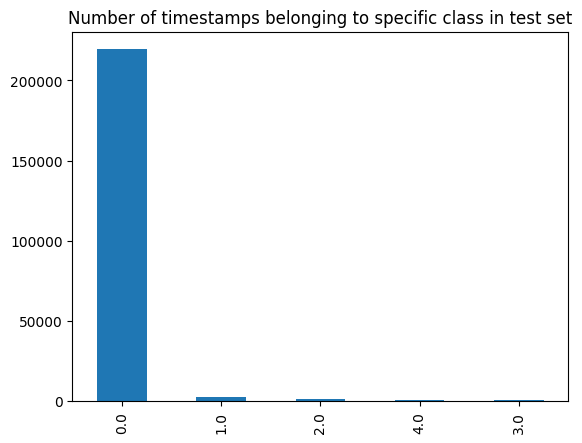

In [121]:
y_test_classes = np.zeros(len(y_test))
condition_class_0 = (y_test['time'] > 48) | (y_test['event'] == False)
y_test_classes[condition_class_0] = 0
condition_class_1 = (y_test['time'] <= 48) & (y_test['time'] > 24) & (y_test['event'] == True)
y_test_classes[condition_class_1] = 1
condition_class_2 = (y_test['time'] <= 24) & (y_test['time'] > 12) & (y_test['event'] == True)
y_test_classes[condition_class_2] = 2
condition_class_3 = (y_test['time'] <= 12) & (y_test['time'] > 6) & (y_test['event'] == True)
y_test_classes[condition_class_3] = 3
condition_class_4 = (y_test['time'] <= 6) & (y_test['event'] == True)
y_test_classes[condition_class_4] = 4
ax = pd.Series(y_test_classes).value_counts().plot.bar()
ax.set_title('Number of timestamps belonging to specific class in test set');

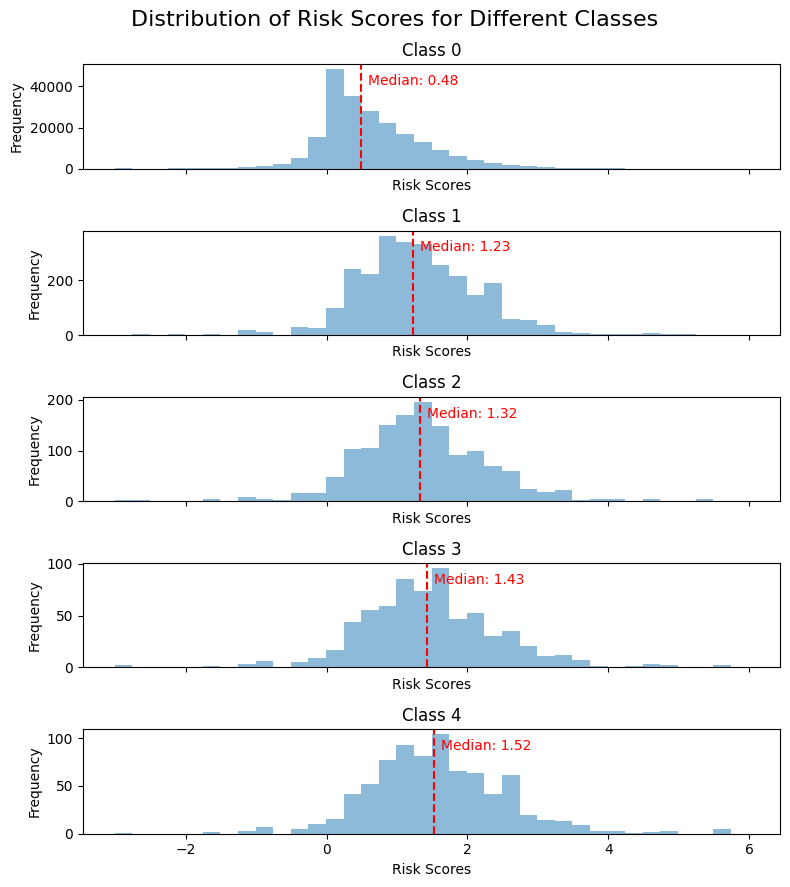

In [122]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Assuming risk_scores, condition_class_0, condition_class_1, ..., condition_class_4 are defined
# Create a figure and axis objects
fig, axes = plt.subplots(figsize=(8, 9), nrows=5, sharex=True)

# Plot histograms for each class
min_ = -3
max_ = 6
risk_scores_plotting = risk_scores.copy()
risk_scores_plotting[risk_scores_plotting < min_] = min_
risk_scores_plotting[risk_scores_plotting > max_] = max_

classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
conditions = [condition_class_0, condition_class_1, condition_class_2, condition_class_3, condition_class_4]

for i, ax in enumerate(axes):
    class_risk_scores = risk_scores_plotting[conditions[i]]
    
    # Plot histogram for the class
    ax.hist(class_risk_scores, bins=np.arange(min_-0.01, max_+0.01, 0.25), alpha=0.5, label=classes[i])
    ax.set_title(classes[i])
    
    # Calculate and plot the median
    median = np.median(class_risk_scores)
    ax.axvline(median, color='r', linestyle='--')
    
    # Add text for the median
    ax.text(median + 0.1, ax.get_ylim()[1] * 0.8, f'Median: {median:.2f}', color='r')

# Add labels and title
for ax in axes:
    ax.set_xlabel('Risk Scores')
    ax.set_ylabel('Frequency')

fig.suptitle('Distribution of Risk Scores for Different Classes', size=16)

fig.tight_layout()
plt.show()


Predict survival function $S(t|x)$.

$$S(t|x) = S_0(t)^{exp(x^T\beta)}$$

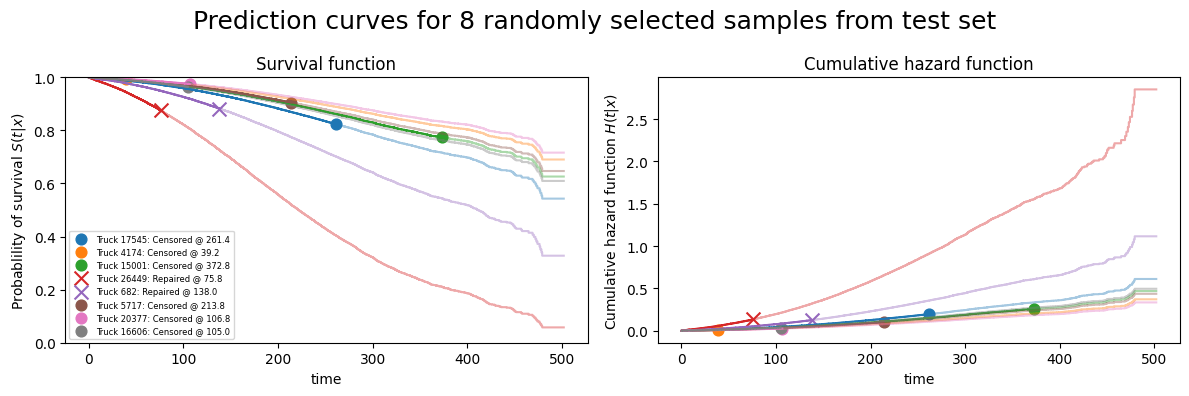

In [132]:
N = 8
np.random.seed(seed=2)
random_indices = np.random.choice(X_test.shape[0], size=N, replace=False, )
surv_funcs = cox_model.predict_survival_function(X_test[random_indices])
chf_funcs = cox_model.predict_cumulative_hazard_function(X_test[random_indices])
is_repaired = y_test[random_indices]['event']
event_times = y_test[random_indices]['time']
trucks = t_test[random_indices]

def plot_function(func, ax, event_times_, trucks_):
    for i, fn in enumerate(func):
        color = next(ax._get_lines.prop_cycler)['color']
        ax.step(fn.x[fn.x <= event_times_[i]], fn(fn.x[fn.x <= event_times_[i]]), where="post", color=color)
        ax.step(fn.x[fn.x > event_times_[i]], fn(fn.x[fn.x > event_times_[i]]), where="post", color=color, alpha=0.4)

        # Add a dot if censored or a cross if the event happened
        if is_repaired[i]:
            l_ = f'Truck {trucks_[i]}: Repaired @ {round(event_times[i], 2)}'
            ax.scatter(event_times_[i], fn(event_times_[i]), label=l_, marker='x', color=color, s=100)  # red cross for repair
        else:
            l_ = f'Truck {trucks_[i]}: Censored @ {round(event_times[i], 2)}'
            ax.scatter(event_times_[i], fn(event_times_[i]), label=l_, marker='o', color=color, s=60)  # blue dot for censoring
    return ax

fig, axes = plt.subplots(figsize=(12, 4), ncols=2, sharex=True, sharey=False)
fig.suptitle(f'Prediction curves for {N} randomly selected samples from test set', size=18)
ax = plot_function(surv_funcs, axes[0], event_times, trucks)
ax.set_ylim(0, 1)
ax.set_xlabel('time')
ax.set_ylabel('Probablility of survival $S(t|x)$')
ax.set_title('Survival function')
ax.legend(fontsize=6)

ax = plot_function(chf_funcs, axes[1], event_times, trucks)
ax.set_xlabel('time')
ax.set_ylabel('Cumulative hazard function $H(t|x)$')
ax.set_title('Cumulative hazard function');
plt.tight_layout();

For each of the trucks from above, how does the actual risk behave over time?

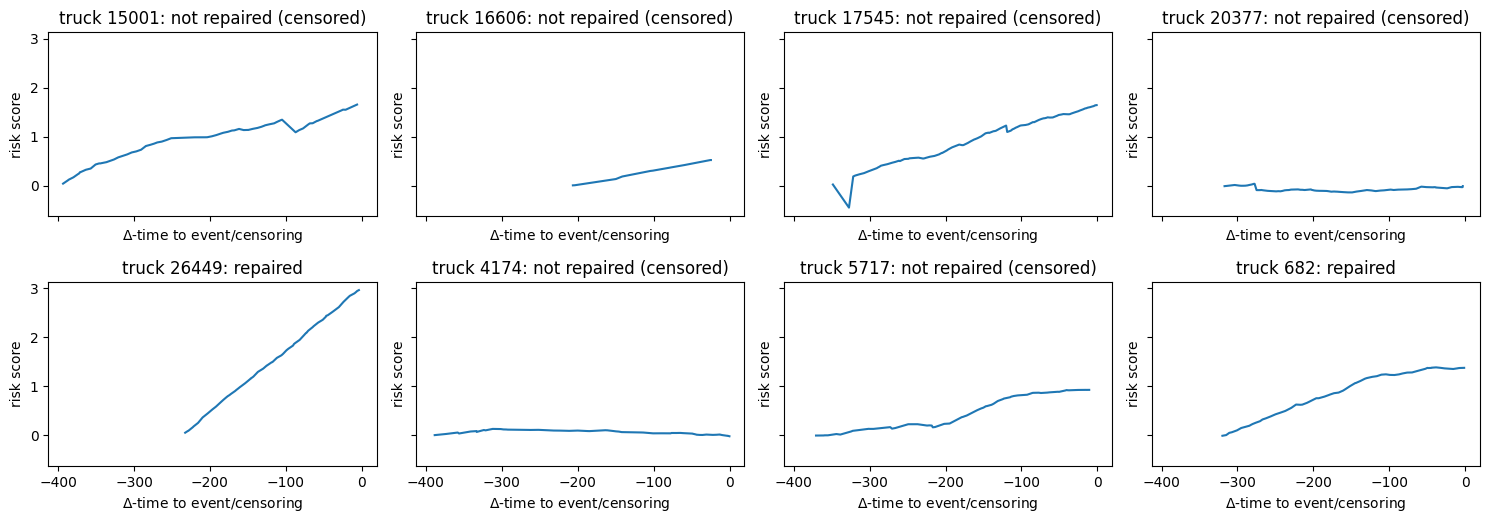

In [163]:
selected_trucks = np.unique(t_test[random_indices])
df_ = df_repair.copy()
df_ = df_.set_index('vehicle_id')
df_.index = df_.index.astype(str)
trucks_to_repair_dict = df_['in_study_repair'].to_dict()

fig, axes = plt.subplots(figsize=(15, N/1.5), nrows=int(N/4), ncols=4, sharex=True, sharey=True)
for truck, ax in zip(selected_trucks, axes.flat):
    repaired_txt = 'repaired' if trucks_to_repair_dict[truck] else 'not repaired (censored)'
    ax.set_title(f'truck {truck}: {repaired_txt}')
    truck_mask = (t_test == truck)
    X_truck, y_truck, r_truck = X_test[truck_mask], y_test[truck_mask], risk_scores[truck_mask]
    ax.plot(-y_truck['time'], r_truck)
    ax.set_xlabel('$\Delta$-time to event/censoring')
    ax.set_ylabel('risk score')

fig.tight_layout();

Illustrate the risk metric over time for repaired and non-repaired trucks:

In [ ]:
pass

Track risk metric over time for specific trucks.

- Compare train and test set
- Problem with data leakage?

In [21]:
X_train_sample.shape

(200000, 105)

  0%|          | 0/100000 [00:00<?, ?it/s]

/root/miniconda3/envs/compact/lib/python3.8/site-packages/sklearn/pipeline.py:427: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


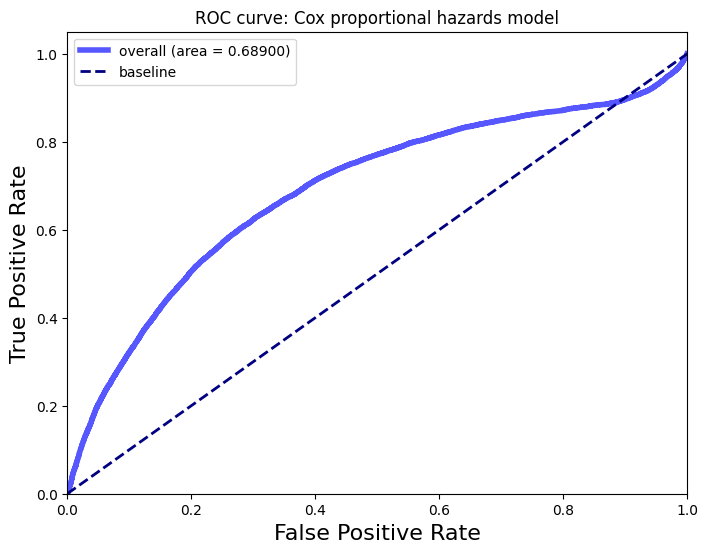

In [22]:
import sklearn.metrics as skmetrics

def calculate_roc_characteristics(distance_vector, anomaly_vector, verbose=False, exact=True):
    
    
    sorted_index_array = np.argsort(distance_vector)

    # Initialize variables to store ROC curve values
    fpr = []
    tpr = []

    if exact: 
        thresholds = distance_vector[sorted_index_array]
    else: 
        min_ = distance_vector[sorted_index_array].min()
        max_ = distance_vector[sorted_index_array].max()
        thresholds = np.arange(min_, max_, (max_ - min_) / 1000)
        print(thresholds)
    for threshold in tqdm(thresholds, disable=(not verbose)):
        predicted_anomaly = distance_vector >= threshold

        # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
        true_positives = ((anomaly_vector == 1) & (predicted_anomaly == 1)).sum()
        false_positives = ((anomaly_vector == 0) & (predicted_anomaly == 1)).sum()
        true_negatives = ((anomaly_vector == 0) & (predicted_anomaly == 0)).sum()
        false_negatives = ((anomaly_vector == 1) & (predicted_anomaly == 0)).sum()

        tpr.append(true_positives / (true_positives + false_negatives))
        fpr.append(false_positives / (false_positives + true_negatives))

    # Calculate the area under the ROC curve (AUC)
    roc_auc = skmetrics.auc(fpr, tpr)

    return fpr, tpr, roc_auc


def plot_roc(fpr, tpr, roc_auc=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    label = f'overall (area = {roc_auc:.5f})' if roc_auc is not None else ''
    ax.plot(fpr, tpr, color='blue', lw=4, label=label, alpha=0.66)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='baseline')
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.05)
    ax.set_title('ROC curve', size=24)
    ax.set_xlabel('False Positive Rate', size=16)
    ax.set_ylabel('True Positive Rate', size=16)
    ax.legend()
    return fig, ax

anomaly_vector = y_test_sample['time'] < 48
fpr, tpr, roc_auc = calculate_roc_characteristics(risk_scores, anomaly_vector, verbose=True, exact=True)
fig, ax = plot_roc(fpr, tpr, roc_auc=roc_auc)
ax.set_title('ROC curve: Cox proportional hazards model');